## Set Up

In [1]:
import torch
import os
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import sys

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
torch.manual_seed(42)

print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
device

Torch: 2.8.0+cpu
CUDA available: False


'cpu'

In [2]:
current_dir = os.path.abspath(os.getcwd())
parent_dir = os.path.dirname(current_dir)
data_dir = os.path.join(parent_dir, "dataset/1/HMU-GC-HE-30K/all_image")
data_dir = os.path.abspath(data_dir) 

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(), #turns image into numpy array
    transforms.Normalize(mean = [0.5,0.5,0.5], std = [0.5,0.5,0.5])
])

loaded_data = datasets.ImageFolder(root = data_dir, transform = transform)

train_size = int(0.8 * len(loaded_data))
val_train = len(loaded_data)-train_size
half_train = int(0.5*val_train)

train_dataset, temp_dataset = random_split(loaded_data, [train_size, val_train])
val_dataset, test_dataset = random_split(temp_dataset, [half_train,half_train])

len(train_dataset), len(val_dataset), len(test_dataset)


(24876, 3110, 3110)

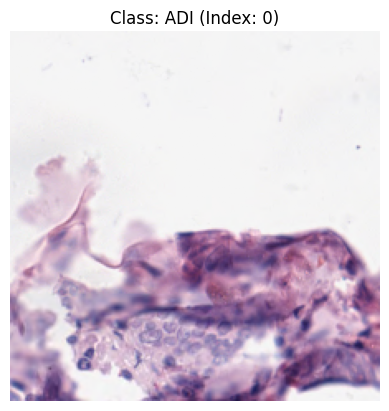

torch.Size([3, 224, 224])


In [4]:
image_tensor, label_index = loaded_data[0]
image_np = image_tensor.permute(1,2,0).numpy() # C, H, W -> H, W, C
image_np = (image_np+1)/2
class_name = loaded_data.classes[0]
plt.imshow(image_np)
plt.title(f"Class: {class_name} (Index: {0})")
plt.axis('off')
plt.show()
print(image_tensor.shape)

In [3]:
train_loader = DataLoader(dataset = train_dataset, shuffle = True, batch_size = 128)
val_loader = DataLoader(dataset = val_dataset, shuffle = False, batch_size = 32)
test_loader = DataLoader(dataset = test_dataset, shuffle = False, batch_size = 32)
len(train_loader), len(val_loader), len(test_loader)


(195, 98, 98)

In [4]:
import torch
import torch.nn as nn

class H_CNN(nn.Module):
    def __init__(self, in_channels=3, num_classes = 8):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, 12, kernel_size = 3) ##224-2 = 222/2 = 111
        self.relu1 = nn.ReLU()
        self.maxP1 = nn.MaxPool2d(2) #takes the max and discards the rest

        self.conv2 = nn.Conv2d(12, 24, kernel_size = 3) ## 111-2 = 109/2= 54
        self.relu2 = nn.ReLU()
        self.maxP2 = nn.MaxPool2d(2)

        self.conv3 = nn.Conv2d(24, 64, kernel_size = 3) ## 54 - 2 = 52 / 2 = 26
        self.relu3 = nn.ReLU()
        self.maxP3 = nn.MaxPool2d(2)

        self.flatten = nn.Flatten()
        self.linear = nn.Linear(43264, num_classes)

    def forward(self, x): #receives X, put through convolution first, self.conv1(x)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxP1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxP2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxP3(x)
        x = self.flatten(x)
        out = self.linear(x)
        return out
        

In [5]:
def accuracy(logits, targets):
    preds = logits.argmax(dim=1)
    # (preds == targets) → boolean tensor showing which predictions are correct
    # .float() → convert True/False to 1.0/0.0
    # .mean() → average across the batch = fraction correct
    # .item() → convert scalar tensor to regular Python float
    return (preds == targets).float().mean().item()
    
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    total_acc = 0
    n_batches = 0
    for x,y in loader:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += accuracy(logits.detach(), y)
        n_batches += 1
    return total_loss/n_batches, total_acc/n_batches
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    total_acc = 0
    n_batches = 0
    with torch.no_grad():
        for x,y in loader:
            x = x.to(device)
            y = y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            total_loss += loss.item()
            total_acc += accuracy(logits, y)
            n_batches += 1
    return total_loss/n_batches,total_acc/n_batches


In [6]:
ffd = []
for i, (data, labels) in enumerate(train_loader):
    if i >= 20:
        break
    ffd.append((data, labels))

ffv = []
for i, (data, labels) in enumerate(val_loader):
    if i >= 5:
        break
    ffv.append((data, labels))

In [8]:
import pandas as pd
model = H_CNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) #if val acc is greater than train then its overfitting a bit, needs regularization

EPOCHS = 10
results = []
for epoch in range(1, EPOCHS + 1):
    tl, ta = train_one_epoch(model, train_loader, optimizer, criterion)
    vl, va = evaluate(model, test_loader, criterion)

    results.append({
        'epoch': epoch,
        'train_loss': tl,
        'train_acc': ta,
        'val_loss': vl,
        'val_acc': va
    })

    print(f"Epoch {epoch:02d} | "
          f"train_loss={tl:.4f} val_loss={vl:.4f} "
          f"train_acc={ta:.4f} val_acc={va:.4f}")
    if epoch%5 == 0:
        torch.save(model.state_dict(), 'Final_Project_Weights')

# Convert to DataFrame for analysis
history_cnn = pd.DataFrame(results)



Epoch 01 | train_loss=1.6247 val_loss=1.4814 train_acc=0.3602 val_acc=0.4239
Epoch 02 | train_loss=1.4042 val_loss=1.4400 train_acc=0.4518 val_acc=0.4423
Epoch 03 | train_loss=1.3548 val_loss=1.3954 train_acc=0.4765 val_acc=0.4532
Epoch 04 | train_loss=1.3255 val_loss=1.3932 train_acc=0.4896 val_acc=0.4592
Epoch 05 | train_loss=1.2969 val_loss=1.3771 train_acc=0.5050 val_acc=0.4676
Epoch 06 | train_loss=1.2639 val_loss=1.3659 train_acc=0.5174 val_acc=0.4756
Epoch 07 | train_loss=1.2335 val_loss=1.3320 train_acc=0.5338 val_acc=0.4870
Epoch 08 | train_loss=1.2075 val_loss=1.3377 train_acc=0.5442 val_acc=0.4864
Epoch 09 | train_loss=1.1819 val_loss=1.3163 train_acc=0.5539 val_acc=0.4928
Epoch 10 | train_loss=1.1509 val_loss=1.3484 train_acc=0.5695 val_acc=0.4867


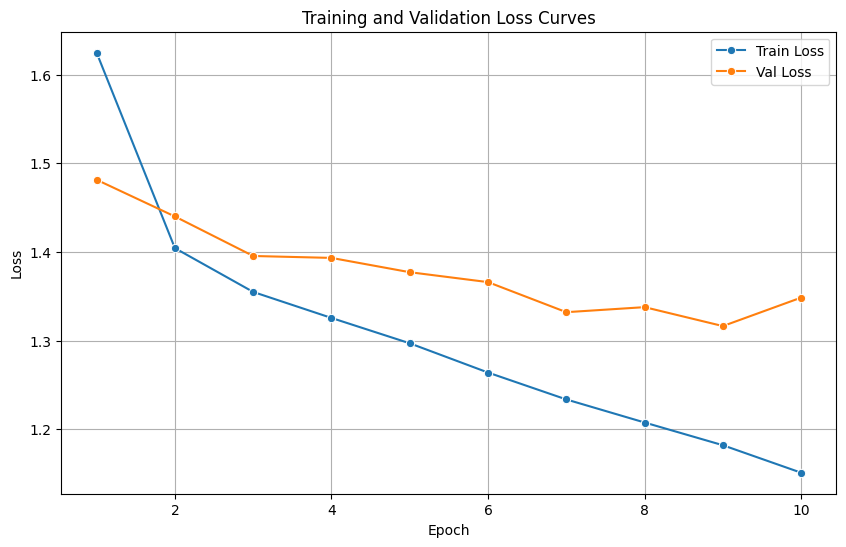

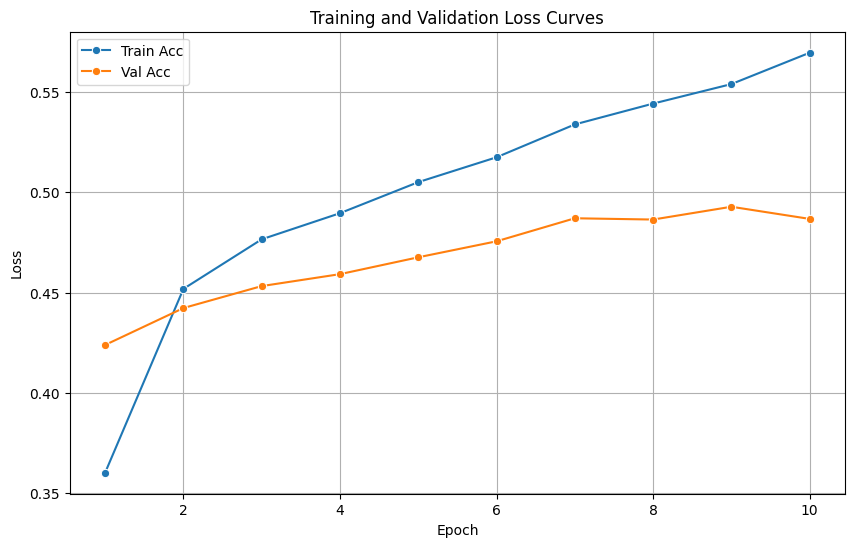

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

epochs = history_cnn['epoch']

plt.figure(figsize=(10, 6))
sns.lineplot(x=epochs, y=history_cnn["train_loss"], marker="o", label="Train Loss")
sns.lineplot(x=epochs, y=history_cnn["val_loss"], marker="o", label="Val Loss")
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x=epochs, y=history_cnn["train_acc"], marker="o", label="Train Acc")
sns.lineplot(x=epochs, y=history_cnn["val_acc"], marker="o", label="Val Acc")
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


In [12]:
model = H_CNN()
model.load_state_dict(torch.load(os.path.join(parent_dir,'model','Final_Project_Weights')))

<All keys matched successfully>

F1 Score (CNN, macro): 0.4582


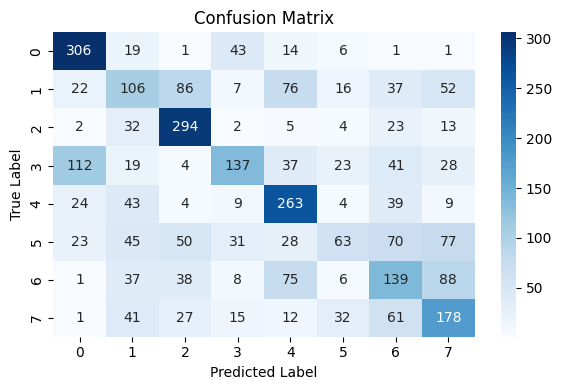

In [16]:
from sklearn.metrics import confusion_matrix, f1_score
# y_true = []
# y_pred = []

# with torch.no_grad():
#     for x, y in test_loader:
#         x = x.to(device)
#         logits = model(x)
#         preds_cnn = logits.argmax(dim=1).cpu()
        
#         y_pred.extend(preds_cnn.tolist())
#         y_true.extend(y.tolist())

cf_matrix = confusion_matrix(y_true, y_pred)
f1_cnn = f1_score(y_true, y_pred, average='macro')
print(f"F1 Score (CNN, macro): {f1_cnn:.4f}")

plt.figure(figsize=(6,4))
sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='d')

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

plt.tight_layout()
plt.show()

In [18]:
import torch
import torch.nn as nn
import torchvision.models as models

class ResNet_pre(nn.Module):
    def __init__(self, num_classes=8):
        super().__init__()
        
        self.base_model = models.resnet18(pretrained=True)
        
        # freeze backbone
        for param in self.base_model.parameters():
            param.requires_grad = False

        in_features = self.base_model.fc.in_features
        
        # replace fc with a trainable classifier
        self.base_model.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)


device = "cuda" if torch.cuda.is_available() else "cpu"
modelRS = ResNet_pre().to(device)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelRS.parameters(), lr=0.0001) 
EPOCHS = 10
resultsRS = []
for epoch in range(1, EPOCHS + 1):
    tl, ta = train_one_epoch(modelRS, train_loader, optimizer, criterion)
    vl, va = evaluate(modelRS, test_loader, criterion)

    resultsRS.append({
        'epoch': epoch,
        'train_loss': tl,
        'train_acc': ta,
        'val_loss': vl,
        'val_acc': va
    })

    print(f"Epoch {epoch:02d} | "
          f"train_loss={tl:.4f} val_loss={vl:.4f} "
          f"train_acc={ta:.4f} val_acc={va:.4f}")
    if epoch%5 == 0:
        torch.save(modelRS.state_dict(), 'RS_Final_Project_Weights')

# Convert to DataFrame for analysis
history_RS_cnn = pd.DataFrame(resultsRS)

C:\Users\monke\anaconda3\envs\csc4505\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\monke\anaconda3\envs\csc4505\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 01 | train_loss=1.8859 val_loss=1.6713 train_acc=0.2910 val_acc=0.4250
Epoch 02 | train_loss=1.5370 val_loss=1.4463 train_acc=0.4764 val_acc=0.4830
Epoch 03 | train_loss=1.3753 val_loss=1.3342 train_acc=0.5242 val_acc=0.5229
Epoch 04 | train_loss=1.2840 val_loss=1.2710 train_acc=0.5502 val_acc=0.5404
Epoch 05 | train_loss=1.2273 val_loss=1.2235 train_acc=0.5622 val_acc=0.5446
Epoch 06 | train_loss=1.1900 val_loss=1.1957 train_acc=0.5709 val_acc=0.5474
Epoch 07 | train_loss=1.1620 val_loss=1.1710 train_acc=0.5790 val_acc=0.5574
Epoch 08 | train_loss=1.1379 val_loss=1.1534 train_acc=0.5835 val_acc=0.5619
Epoch 09 | train_loss=1.1203 val_loss=1.1381 train_acc=0.5906 val_acc=0.5673
Epoch 10 | train_loss=1.1035 val_loss=1.1293 train_acc=0.5944 val_acc=0.5644


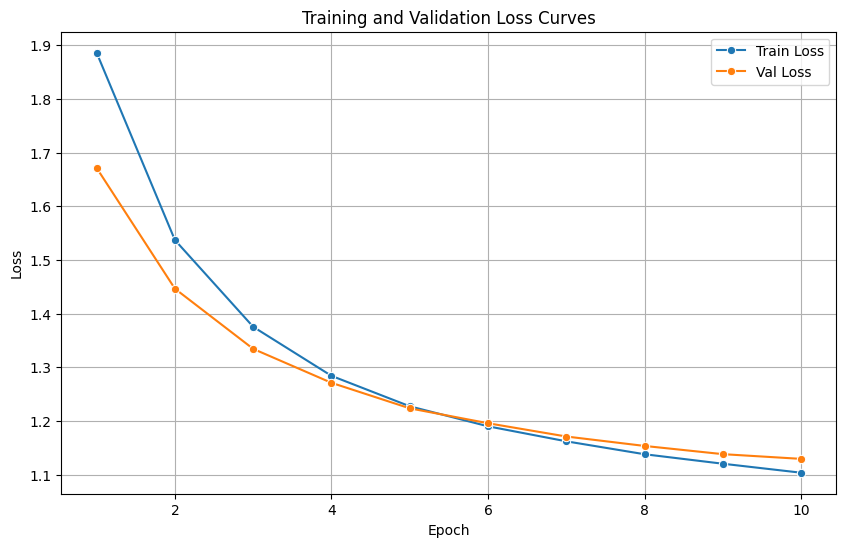

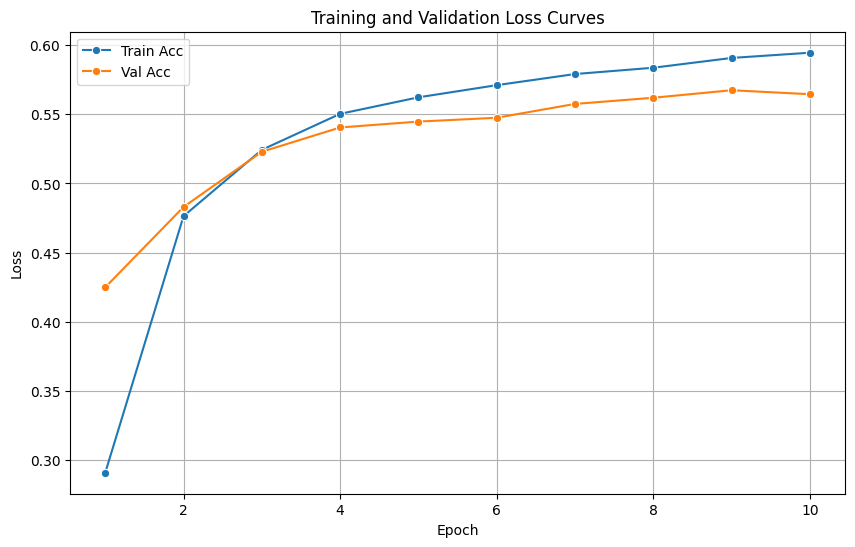

In [20]:

epochs = history_RS_cnn['epoch']

plt.figure(figsize=(10, 6))
sns.lineplot(x=epochs, y=history_RS_cnn["train_loss"], marker="o", label="Train Loss")
sns.lineplot(x=epochs, y=history_RS_cnn["val_loss"], marker="o", label="Val Loss")
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x=epochs, y=history_RS_cnn["train_acc"], marker="o", label="Train Acc")
sns.lineplot(x=epochs, y=history_RS_cnn["val_acc"], marker="o", label="Val Acc")
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


In [21]:
import pandas as pd
history_RS_cnn = pd.DataFrame(resultsRS)

F1 Score (CNN, macro): 0.5628


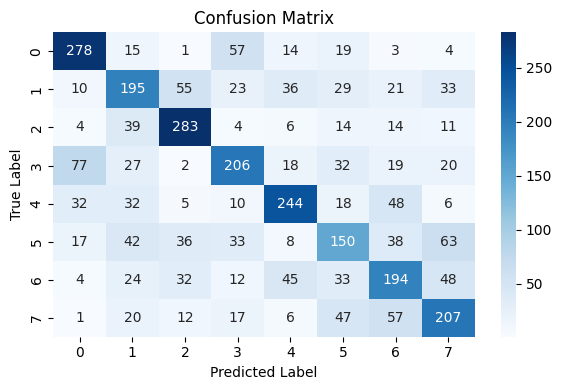

In [22]:
from sklearn.metrics import confusion_matrix, f1_score
y_true = []
y_pred = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        logits = modelRS(x)
        preds_cnn = logits.argmax(dim=1).cpu()
        
        y_pred.extend(preds_cnn.tolist())
        y_true.extend(y.tolist())

cf_matrix = confusion_matrix(y_true, y_pred)
f1_cnn = f1_score(y_true, y_pred, average='macro')
print(f"F1 Score (CNN, macro): {f1_cnn:.4f}")

plt.figure(figsize=(6,4))
sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='d')

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

plt.tight_layout()
plt.show()

In [26]:
class ResNet_pre_add(nn.Module):
    def __init__(self, num_classes=8):
        super().__init__()
        self.base_model = models.resnet18(pretrained=True)
        in_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Identity()

        self.fc = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

        for name, param in self.base_model.named_parameters():
            if "layer4" in name:   
                param.requires_grad = True
            else:
                param.requires_grad = False

    def forward(self, x):
        x = self.base_model(x)  
        x = self.fc(x)           
        return x
        

modelRS_add = ResNet_pre_add().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelRS_add.parameters(), lr=0.0001) 
EPOCHS = 10
resultsRS_add = []
for epoch in range(1, EPOCHS + 1):
    tl, ta = train_one_epoch(modelRS_add, train_loader, optimizer, criterion)
    vl, va = evaluate(modelRS_add, test_loader, criterion)

    resultsRS_add.append({
        'epoch': epoch,
        'train_loss': tl,
        'train_acc': ta,
        'val_loss': vl,
        'val_acc': va
    })

    print(f"Epoch {epoch:02d} | "
          f"train_loss={tl:.4f} val_loss={vl:.4f} "
          f"train_acc={ta:.4f} val_acc={va:.4f}")
    if epoch%5 == 0:
        torch.save(modelRS_add.state_dict(), 'RS_add_Final_Project_Weights')

# Convert to DataFrame for analysis
history_RS_add_cnn = pd.DataFrame(resultsRS_add)

C:\Users\monke\anaconda3\envs\csc4505\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\monke\anaconda3\envs\csc4505\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 01 | train_loss=1.1170 val_loss=0.8625 train_acc=0.5937 val_acc=0.6687
Epoch 02 | train_loss=0.7246 val_loss=0.7850 train_acc=0.7381 val_acc=0.7056
Epoch 03 | train_loss=0.4469 val_loss=0.8401 train_acc=0.8444 val_acc=0.7037
Epoch 04 | train_loss=0.1896 val_loss=0.9956 train_acc=0.9426 val_acc=0.6921
Epoch 05 | train_loss=0.0695 val_loss=1.1407 train_acc=0.9836 val_acc=0.6903
Epoch 06 | train_loss=0.0364 val_loss=1.1711 train_acc=0.9921 val_acc=0.6983
Epoch 07 | train_loss=0.0232 val_loss=1.2450 train_acc=0.9950 val_acc=0.6914
Epoch 08 | train_loss=0.0195 val_loss=1.3566 train_acc=0.9954 val_acc=0.6882
Epoch 09 | train_loss=0.0192 val_loss=1.5209 train_acc=0.9953 val_acc=0.6785
Epoch 10 | train_loss=0.0188 val_loss=1.5544 train_acc=0.9952 val_acc=0.6841


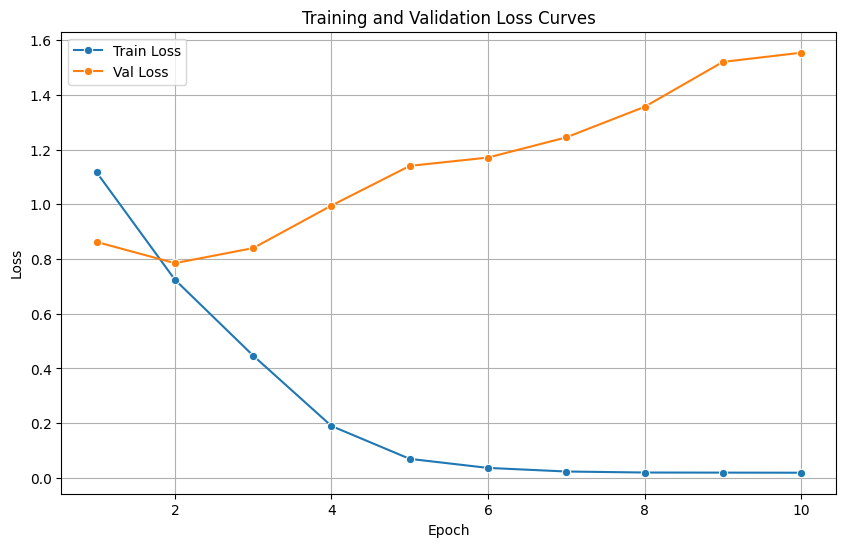

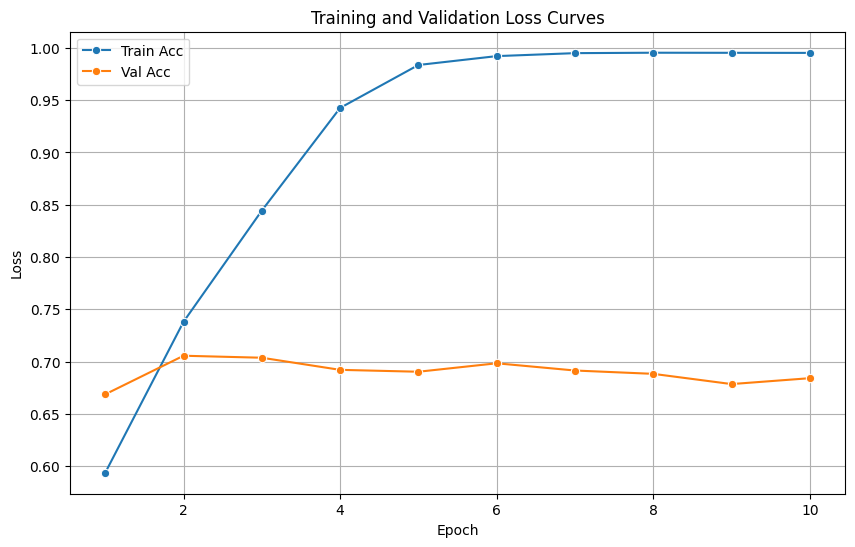

In [29]:

epochs = history_RS_add_cnn['epoch']

plt.figure(figsize=(10, 6))
sns.lineplot(x=epochs, y=history_RS_add_cnn["train_loss"], marker="o", label="Train Loss")
sns.lineplot(x=epochs, y=history_RS_add_cnn["val_loss"], marker="o", label="Val Loss")
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x=epochs, y=history_RS_add_cnn["train_acc"], marker="o", label="Train Acc")
sns.lineplot(x=epochs, y=history_RS_add_cnn["val_acc"], marker="o", label="Val Acc")
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


F1 Score (CNN, macro): 0.6848


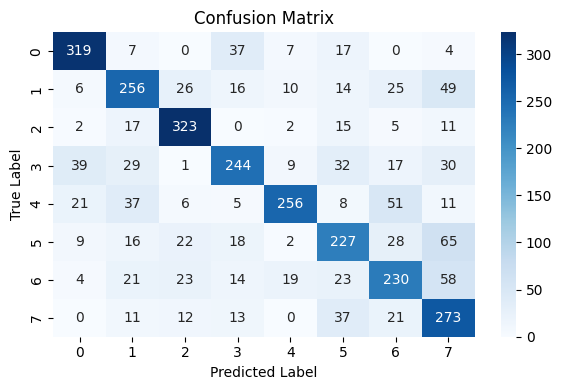

In [30]:
from sklearn.metrics import confusion_matrix, f1_score
y_true = []
y_pred = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        logits = modelRS_add(x)
        preds_cnn = logits.argmax(dim=1).cpu()
        
        y_pred.extend(preds_cnn.tolist())
        y_true.extend(y.tolist())

cf_matrix = confusion_matrix(y_true, y_pred)
f1_cnn = f1_score(y_true, y_pred, average='macro')
print(f"F1 Score (CNN, macro): {f1_cnn:.4f}")

plt.figure(figsize=(6,4))
sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='d')

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

plt.tight_layout()
plt.show()